# Image Translation

This will provide you an introduction image translation formulated as a regression problem using a residual U-Net model.
Hopefully you will be acqainted with the U-Net model by now. At its core, it's an autoencoder, consisting of an encoder (downsampling) part and a decoder (upsampling) part. The U-Net model has become immensely popular in many image analysis tasks, and one of its main strengths are the skip connections between the encoder and decoder layers which allows the model to capture details at and near the input level resolution. If you've seen U-Nets being used for image segmentation previously, you only need minor adjustments to adapt it to image regression, by changing the loss function and the final activation layer (more on that later).

Below is an overview of the 2D U-Net model architecture as in the original paper (figure courtesy of [Uni Freiburg](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)). We'll be using a very similar architecture but with same padding, which means we pad the input image so the input image and the output image will have the same shape after covolution. We also have a short skip connection within each block in addtion to the long skip connections in the original U-Net.  

![U-Net architecture](u-net-architecture.png)

## 0. Import libraries and set paths

Let's start with some imports. We'll be using the open source U-Net repository [microDL](https://github.com/czbiohub/microDL) , so we'll import that along with some plotting and other utility packages.


In [1]:
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
import pandas as pd
import pprint
import sys

import micro_dl.cli.image_inference as inference
import micro_dl.cli.train_script as train
import micro_dl.cli.preprocess_script as preprocess
import micro_dl.utils.aux_utils as aux_utils
import micro_dl.utils.image_utils as im_utils
import micro_dl.utils.masks as mask_utils
import micro_dl.utils.normalize as norm_utils
import micro_dl.utils.train_utils as train_utils

# Add module path to sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Setup pretty print
pp = pprint.PrettyPrinter(indent=4)

Using TensorFlow backend.


/home/paperspace/Code/microDL


Next, we define paths where input images are stored and where processed data and model will be stored. The goal of this exercise is to translate 2D slices of brightfield image into 2D slices of fluorescene images of F-actin and DNA.

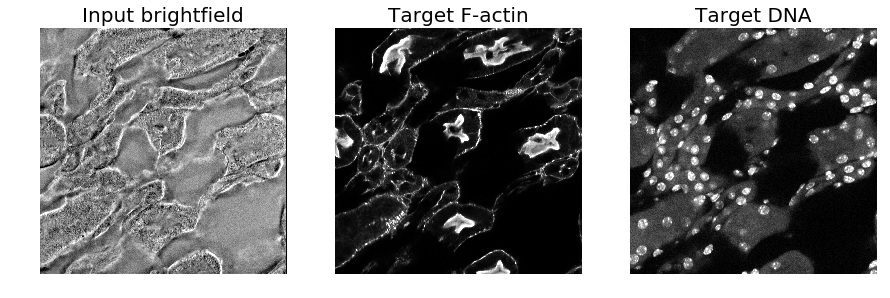

In [3]:
# First of all we'll define some paths we'll be reading data from and saving to
# This is the directory where our imaging data is downloaded
INPUT_DIR = '/home/paperspace/Data/MBL_DL_image_translation/data/'
# And specify where we want to store our preprocessed data
PREPROC_OUTPUT_DIR = '/home/paperspace/Data/translation_preprocessed_data/'
# This is where the model weights and related variables will be stored
MODEL_DIR = '/home/paperspace/Data/translation_model_adam_mae'


# View example images.
actin_path = os.path.join(INPUT_DIR, 'img_568_t000_p003_z010.tif')
dna_path=os.path.join(INPUT_DIR, 'img_405_t000_p003_z010.tif')
bf_path=os.path.join(INPUT_DIR,'img_Transmission_t000_p003_z010.tif')
actin = im_utils.read_image(actin_path)
actin=norm_utils.hist_clipping(actin, 1, 99)
dna = im_utils.read_image(dna_path)
dna = norm_utils.hist_clipping(dna, 1, 99)
brightfield = im_utils.read_image(bf_path) 
brightfield = norm_utils.hist_clipping(brightfield, 0.8, 99.5) 


plt.subplot(131); plt.imshow(brightfield, cmap='gray'); plt.axis('off')
plt.title('Input brightfield',fontSize=20)
plt.subplot(132); plt.imshow(actin, cmap='gray'); plt.axis('off')
plt.title('Target F-actin',fontSize=20)
plt.subplot(133); plt.imshow(dna, cmap='gray'); plt.axis('off')
plt.title('Target DNA',fontSize=20)
plt.rcParams['figure.figsize'] = [20, 15]
plt.show()


# Session 1: image translation (slice$\rightarrow$slice) on small dataset 

## 1. Preprocessing

We will  be using three main modules of microDL for image translation: preprocessing, training and inference (see imports above).

The first step is the preprocessing. We have some options like resizing, flatfield correction, creating masks, and tiling. The data we're working with is already background corrected so we can safely skip that part. We also don't need to resize the images.

We would however like to create masks based on our target data. The reason for that is that we would like to avoid training on background only, that is empty or near empty tiles. A threshold we found reasonable is to make sure that our tiles contain 25% signal or more.

We would also like to tile our images. The original image size (2048 x 2048 pixels) is too large to be able to fit into memory and similar structures reappear across the images. So we'd be much better off splitting the images into smalle pieces (tiles). A design consideration for convolution neural networks is the [receptive field](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807), which is the region of the input space a given feature is looking at. Given the size of our structures of interest and our network architecture, we use 256 x 256 pixel tiles. Also, training on smaller tiles allow us to use bigger batch size so the training converges faster.

### A. Masks

We would like to generate binary masks based on our target channel. Let's for now assume our target channel is channel index = 2. In microDL we have two types of global binary thresholding methods builtin, [Otsu](https://en.wikipedia.org/wiki/Otsu%27s_method) and [unimodal](https://users.cs.cf.ac.uk/Paul.Rosin/resources/papers/unimodal2.pdf) (or Rosin) thresholding.
Let's load an image, generate masks and plot them side by side.

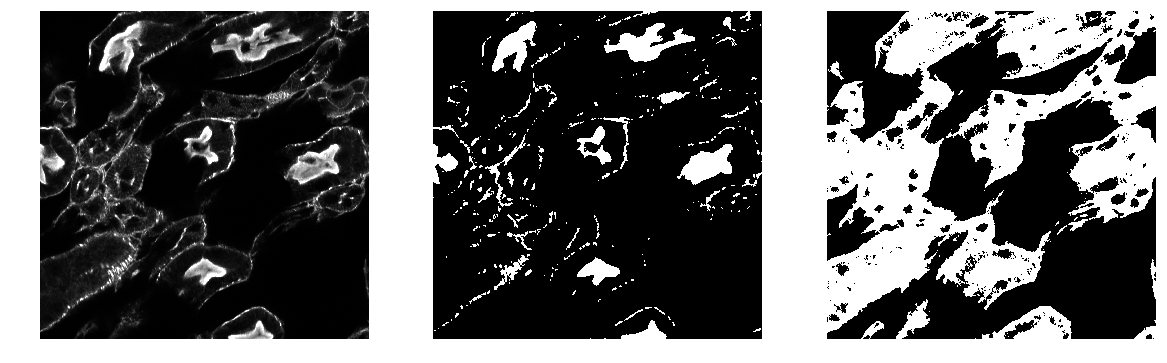

In [4]:
# Load image
im_path = os.path.join(INPUT_DIR, 'img_568_t000_p003_z010.tif')
im = im_utils.read_image(im_path)
# Clip top and bottom 1% of histogram for better visualization
im = norm_utils.hist_clipping(im, 1, 99)

mask_otsu = mask_utils.create_otsu_mask(im)
mask_rosin = mask_utils.create_unimodal_mask(im)

plt.subplot(131); plt.imshow(im, cmap='gray'); plt.axis('off')
plt.subplot(132); plt.imshow(mask_otsu, cmap='gray'); plt.axis('off')
plt.subplot(133); plt.imshow(mask_rosin, cmap='gray'); plt.axis('off')
plt.rcParams['figure.figsize'] = [30, 20]
plt.show()

As you can see, the Otsu threshold captures only the very bright structures and misses dim structures. Rosin thresholding does a better job at these dim structures, so we'll be using Rosin thresholding for the analysis.

### B.  Preprocessing configuration

Usually we run microDL through command line interfaces (CLIs), which is to say we just input commands in the terminal. For each module we specify the path to a config file as a command line argument. Since we're using Jupyter Notebook for this tutorial we will instead load, the preprocessing config so we can take a look at it.

In [5]:
config_path = os.path.join(
    module_path,
    'micro_dl/config_preprocess.yml',
)
preproc_config = aux_utils.read_config(config_path)
pp.pprint(preproc_config)

{   'channel_ids': [0, 1, 2],
    'flat_field': {'estimate': True},
    'input_dir': '/Users/jenny.folkesson/Data/SMS-2018-07-03-18-35-00-0010',
    'masks': {   'channels': [1],
                 'mask_ext': 'png',
                 'mask_type': 'otsu',
                 'str_elem_radius': 3},
    'num_workers': 4,
    'output_dir': '/Users/jenny.folkesson/Data/SMS-2018-07-03-18-35-00-0010_train_data',
    'pos_ids': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'resize': {'resize_3d': False, 'scale_factor': 2},
    'slice_ids': [10, 11, 12, 13, 14, 15],
    'tile': {   'depths': [1, 1, 1],
                'image_format': 'zyx',
                'mask_depth': 1,
                'min_fraction': 0.25,
                'save_tiled_masks': True,
                'step_size': [128, 128],
                'tile_size': [256, 256]},
    'verbose': 10}


In [6]:
# There are some things we need to change around here. We're not doing resizing so let's remove that key
if 'resize' in preproc_config:
    preproc_config.pop('resize')
# We're not doing flatfield correction either
if 'flat_field' in preproc_config:
    preproc_config.pop('flat_field')
    
# We need to change input_dir to point to where our image data is located
preproc_config['input_dir'] = INPUT_DIR
# And where we want to store our preprocessed data
preproc_config['output_dir'] = PREPROC_OUTPUT_DIR

# Switch to unimodal (Rosin) thresholding
preproc_config['masks']['mask_type'] = 'unimodal'

# Our VMs have 8 cores so adjust the number of workers
preproc_config['num_workers'] = 8

# Let's look again
pp.pprint(preproc_config)

{   'channel_ids': [0, 1, 2],
    'input_dir': '/home/paperspace/Data/MBL_DL_image_translation/data/',
    'masks': {   'channels': [1],
                 'mask_ext': 'png',
                 'mask_type': 'unimodal',
                 'str_elem_radius': 3},
    'num_workers': 8,
    'output_dir': '/home/paperspace/Data/translation_preprocessed_data/',
    'pos_ids': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'slice_ids': [10, 11, 12, 13, 14, 15],
    'tile': {   'depths': [1, 1, 1],
                'image_format': 'zyx',
                'mask_depth': 1,
                'min_fraction': 0.25,
                'save_tiled_masks': True,
                'step_size': [128, 128],
                'tile_size': [256, 256]},
    'verbose': 10}


In [7]:
# Now let's break apart our config and also set some other parameters
# Typically microscopy images are indexed along channels, time, FOV (position) and slice (z)
# index of -1 mean include all indices
slice_ids = -1
if 'slice_ids' in preproc_config:
    slice_ids = preproc_config['slice_ids']
time_ids = -1
if 'time_ids' in preproc_config:
    time_ids = preproc_config['time_ids']
pos_ids = -1
if 'pos_ids' in preproc_config:
    pos_ids = preproc_config['pos_ids']
channel_ids = -1
if 'channel_ids' in preproc_config:
    channel_ids = preproc_config['channel_ids']
# The images are uniform in size
uniform_struct = True
# How many chars an index should be encoded as
int2str_len = 3
# Number of processes to use
num_workers = 4
if 'num_workers' in preproc_config:
    num_workers = preproc_config['num_workers']

base_config = {'input_dir': INPUT_DIR,
               'output_dir': PREPROC_OUTPUT_DIR,
               'slice_ids': slice_ids,
               'time_ids': time_ids,
               'pos_ids': pos_ids,
               'channel_ids': channel_ids,
               'uniform_struct': uniform_struct,
               'int2strlen': int2str_len,
               'num_workers': num_workers}

# Let's look at the base_config we just generated
pp.pprint(base_config)

{   'channel_ids': [0, 1, 2],
    'input_dir': '/home/paperspace/Data/MBL_DL_image_translation/data/',
    'int2strlen': 3,
    'num_workers': 8,
    'output_dir': '/home/paperspace/Data/translation_preprocessed_data/',
    'pos_ids': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'slice_ids': [10, 11, 12, 13, 14, 15],
    'time_ids': -1,
    'uniform_struct': True}


### C. Preprocess data

In [8]:
# Now it's time to do run the preprocessing: about a minute runtime.
preproc_config, runtime = preprocess.pre_process(preproc_config, base_config)
print("Preprocessing took {} seconds".format(runtime))
# Save the final config and run time
preprocess.save_config(preproc_config, runtime)

Tile dir exists. Only add untiled channels.
Preprocessing took 68.17902278900146 seconds


You can navigate to your output_dir and take a look at what was generated. You will find a mask_dir containing masks, a tile_dir containing tiles and JSON file containing the all the information that was used to generated the preprocessed data. Let's take a look at a few tiles.

/home/paperspace/Data/translation_preprocessed_data/tiles_256-256_step_128-128
[14677  8540 20136 27797  1280]
im_c001_z015_t000_p011_r640-896_c768-1024_sl0-1.npy im shape (1, 256, 256)
im_c001_z011_t000_p003_r1408-1664_c128-384_sl0-1.npy im shape (1, 256, 256)
im_c002_z014_t000_p007_r384-640_c1408-1664_sl0-1.npy im shape (1, 256, 256)
im_c003_z014_t000_p009_r256-512_c512-768_sl0-1.npy im shape (1, 256, 256)
im_c000_z011_t000_p004_r128-384_c1536-1792_sl0-1.npy im shape (1, 256, 256)


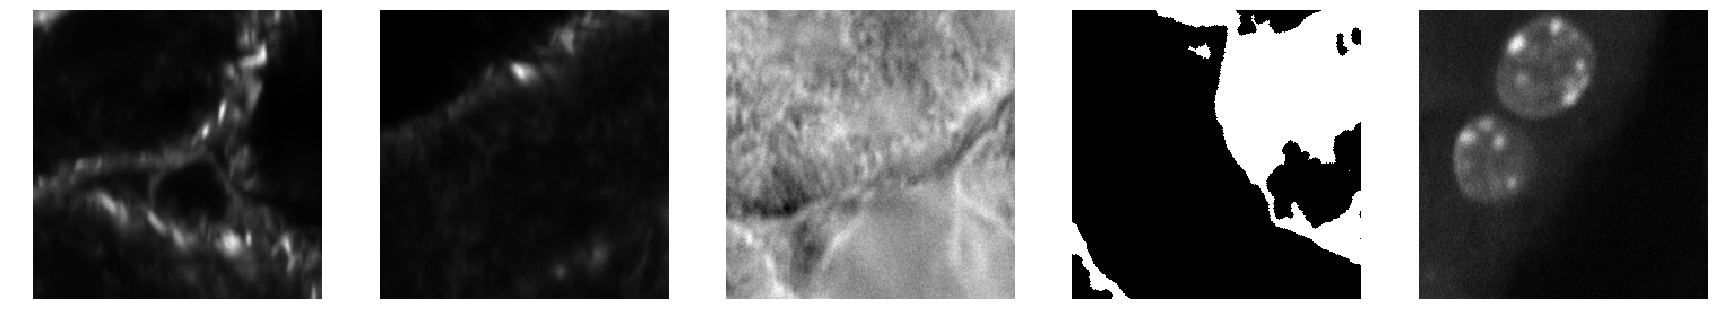

In [9]:
tile_dir = preproc_config['tile']['tile_dir']
print(tile_dir)
frames_meta = pd.read_csv(os.path.join(tile_dir, 'frames_meta.csv'))
# Randomly select 5 tiles and plot them
subset = np.random.choice(frames_meta.shape[0], 5, replace=False)
print(subset)
for i in range(5):
    im = im_utils.read_image(os.path.join(tile_dir, frames_meta.loc[subset[i], 'file_name']))
    print(frames_meta.loc[subset[i], 'file_name'], 'im shape', im.shape)
    plt.subplot(1, 5, i + 1); plt.imshow(np.squeeze(im), cmap='gray'); plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

##  2. Training 
Now that we've preprocessed our data we're ready to train. During this exercise, we will use brightfield image to predict two different fluorescent channels, actin and nuclei.
In our dataset, the channel names and indices are the following:

* Brightfield: channel name Transmission, index 2
* Actin:channel name 568, index 1
* Nuclei: channel name 405, index 0

### A.  Training configuration

We specify the network architecture and training parameters using another config file. Let's load a base 2D training config file and take a look.

In [11]:
config_path = os.path.join(
    module_path,
    'micro_dl/config.yml',
)
train_config = aux_utils.read_config(config_path)
pp.pprint(train_config)

{   'dataset': {   'data_dir': '/data/anitha/label_free/image_tile_256-256_step_256-256',
                   'height': 256,
                   'input_channels': [3],
                   'random_seed': 42,
                   'split_by_column': 'pos_idx',
                   'split_ratio': {'test': 0.2, 'train': 0.6, 'val': 0.2},
                   'target_channels': [0],
                   'width': 256},
    'network': {   'activation': {'type': 'relu'},
                   'batch_norm': True,
                   'block_sequence': 'conv-activation-bn',
                   'class': 'UNet2D',
                   'data_format': 'channels_first',
                   'depth': 1,
                   'dropout': 0,
                   'dropout_dense': 0.4,
                   'filter_size': 3,
                   'final_activation': 'linear',
                   'height': 256,
                   'num_convs_per_block': 2,
                   'num_filters_per_block': [8, 16, 32, 64, 128],
                   '

There are a lot more options here, as you can see. The first things to check for when doing image translation is that the final activation is linear. Unlike for binary segmentation when we want to use a sigmoid to move values towards either zero or one, we would here like to do a regression and not apply any transform to our output signal.

There are some variables that it would be interesting for you to explore while training:

#### Loss
The second thing is to choose a loss function that makes sense. Common choices for regression are the mean squared error (MSE) and the mean absolute error (MAE) between the target image y and the estimated image y':
\begin{equation*}
MSE = \sum_{p} (y_p - y_p')^2,
\end{equation*}

\begin{equation*}
MAE = \sum_{p} |y_p - y_p'|
\end{equation*}
for each pixel index p.

You can try both by changing train_config['trainer']['loss']. The names in microDL for losses are mse_loss and mae_loss, respectively. You can also try other custom losses by using the loss function names [here](https://github.com/czbiohub/microDL/blob/master/micro_dl/train/losses.py), or any standard [Keras loss function](https://keras.io/losses/) by specifying the loss function name defined by Keras. 

#### Optimizer
A good default choice of optimizer is Adam. You can read more about different deep learning optimizers [here](http://ruder.io/optimizing-gradient-descent/), and you can change the optimizer you'd like to use in your training by changing the variable train_config['trainer']['optimizer']['name'] to any of the Keras optimizers listed [here](https://keras.io/optimizers/).

#### Learning Rate
If the learning rate is too small your training might take a very long time to converge, and if it's too big it might not converge at all. It's worth trying some different values and see what happens with convergence.

#### Dropout
Since we're working with a very small dataset in exploratory training, chances are that your network will overfit to your training data. It's worth exploring train_config['network']['dropout'] and to see if increasing those variables can reduce overfitting.

#### Numer of filters
The number of filters in each layer of the model controls the model capacity. This parameter is train_config['network']['num_filters_per_block']. Too large model capacity can lead to overfitting and not necesssarily better results.

#### Augmentation
The data is flipped and rotated randomly to diversify the training set and mitigate overfitting.

#### Other?
If you have extra time or are curious about the other variables, feel free to explore.

In [13]:
# For our training config, we need to make some initial adjustments
# Set the data directory to the directory we generated during preprocessing
train_config['dataset']['data_dir'] = PREPROC_OUTPUT_DIR
# We also need to specify where we want to store our model and all related data generated by training
# This directory will be created if it doesn't already exist
train_config['trainer']['model_dir'] = MODEL_DIR
# Set maximum number of epochs to 6 so we can explore difference parameters quickly
train_config['trainer']['max_epochs'] = 6
# Predict actin (channel 1) from brightfield (channel 2)
train_config['dataset']['input_channels'] = [2]
train_config['dataset']['target_channels'] = [1]

# Enable data augmentation.
train_config['dataset']['augmentation'] = True


In [15]:
# Time to train. First, let see what GPU resources are available
gpu_id, gpu_mem_frac = train_utils.select_gpu()

Using GPU 0 with memory fraction 0.9645275319792804.


In [16]:
# Try restarting the notebook kernel if you run into errors about "can't creat training session".
# takes about 5 min.
train.run_action(
    action='train',
    config=train_config,
    gpu_ids=gpu_id,
    gpu_mem_frac=gpu_mem_frac,
)

Instructions for updating:
Colocations handled automatically by placer.


Model compiled
Steps per epoch: 144


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 256, 256)  80          input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 8, 256, 256)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 8, 256, 256)  32          activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/6
144/144 [==============================] - 46s 323ms/step - loss: 0.8242 - pearson_corr: 0.1027 - val_loss: 0.6954 - val_pearson_corr: 0.1485

Epoch 00001: val_loss improved from inf to 0.69545, saving model to /home/paperspace/Data/translation_model_adam_mae/Model_2019-05-11-19-48-59.hdf5
Epoch 2/6
144/144 [==============================] - 41s 282ms/step - loss: 0.6149 - pearson_corr: 0.3543 - val_loss: 0.6863 - val_pearson_corr: 0.1153

Epoch 00002: val_loss improved from 0.69545 to 0.68627, saving model to /home/paperspace/Data/translation_model_adam_mae/Model_2019-05-11-19-48-59.hdf5
Epoch 3/6
144/144 [==============================] - 41s 282ms/step - loss: 0.5659 - pearson_corr: 0.4743 - val_loss: 0.6143 - val_pearson_corr: 0.3289

Epoch 00003: val_loss improved from 0.68627 to 0.61435, saving model to /home/paperspace/Data/translation_model_adam_mae/Model_2019-05-11-19-48-59.hdf5
Epoch 4/6
144/144 [==============================] - 41s 283ms/step - loss: 0.5179 - pear

Training time: 259.2504563331604



Epoch 00006: val_loss did not improve from 0.56982


We've completed our first training. Let's take a look at what happened during training by opening a history log file.

In [17]:
history = pd.read_csv(os.path.join(MODEL_DIR, 'history.csv'))
history.head()

,epoch,loss,pearson_corr,val_loss,val_pearson_corr
0,0,0.823506,0.103570,0.695447,0.148548
1,1,0.616169,0.354178,0.686273,0.115252
2,2,0.564164,0.475582,0.614348,0.328944
3,3,0.517567,0.571423,0.569820,0.472696
4,4,0.480812,0.637457,0.570865,0.492051


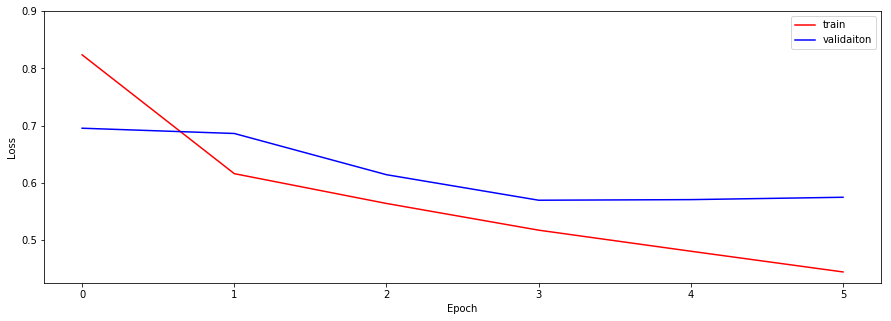

In [18]:
# Plot training vs. validation loss
plt.plot(history.epoch, history.loss, 'r')
plt.plot(history.epoch, history.val_loss, 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(top=.9)
plt.legend(['train', 'validaiton'])
plt.show()

Does it look like the model is overfitting? How can you tell?


## 3. Predictions on test set

We'd also like to see how well the model performs predictions. For that we will have to run inference on our test dataset. We will run model inference on the full zie 2048 X 2048 image instead of on tiles in training. Why can we run the model inference on different input size? And what are the benefits of doing that?   

In [19]:
inference.run_prediction(
    model_dir=MODEL_DIR,
    image_dir=INPUT_DIR,
    gpu_ids=gpu_id,
    gpu_mem_frac=gpu_mem_frac,
    metrics=['ssim', 'pearson_corr', 'coeff_determination'],
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, None, None 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 8, None, None 80          input_2[0][0]                    
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 8, None, None 0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 8, None, None 32          activation_20[0][0]              
__________________________________________________________________________________________________
conv2d_25 

Inference time: 4.768544673919678
1/1 [==============================] - 3s 3s/step
Inference time: 0.3352043628692627
1/1 [==============================] - 0s 389ms/step
Inference time: 0.33331298828125
1/1 [==============================] - 0s 381ms/step
Inference time: 0.3331873416900635
1/1 [==============================] - 0s 392ms/step
Inference time: 0.3329446315765381
1/1 [==============================] - 0s 378ms/step
Inference time: 0.331392765045166
1/1 [==============================] - 0s 396ms/step
Inference time: 0.33319830894470215
1/1 [==============================] - 0s 378ms/step
Inference time: 0.332507848739624
1/1 [==============================] - 0s 387ms/step
Inference time: 0.3291018009185791
1/1 [==============================] - 0s 377ms/step
Inference time: 0.3334805965423584
1/1 [==============================] - 0s 389ms/step
Inference time: 0.3336193561553955
1/1 [==============================] - 0s 379ms/step
Inference time: 0.3290538787841797
1/1 

In [20]:
# There should be a new subdirectory created the model directory with the predictions and the metrics
pred_dir = os.path.join(MODEL_DIR, 'predictions')
# See what images are generated
glob.glob(os.path.join(pred_dir, '*'))

['/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z011_t000_p011.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z013_t000_p011.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z015_t000_p011.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z014_t000_p004.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z014_t000_p011.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z010_t000_p011.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z012_t000_p011.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z015_t000_p004.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z012_t000_p004.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z010_t000_p004.tif',
 '/home/paperspace/Data/translation_model_adam_mae/predictions/im_c002_z013_t000

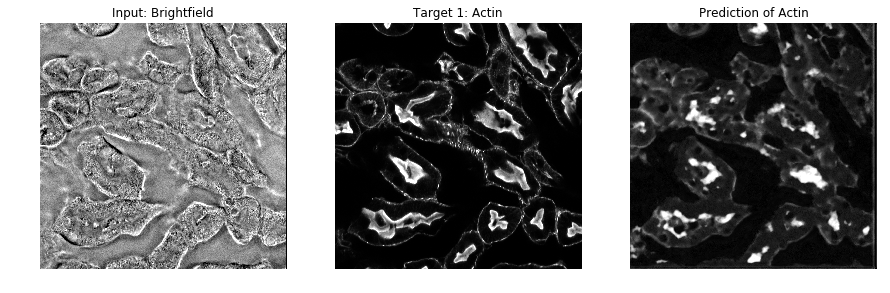

In [21]:
# Plot input, target and prediction side by side
im_path = os.path.join(INPUT_DIR, 'img_Transmission_t000_p011_z013.tif')
im = im_utils.read_image(im_path)
im = norm_utils.hist_clipping(im, 1, 99)
plt.subplot(131); plt.imshow(im, cmap='gray'); plt.title('Input: Brightfield'); plt.axis('off')
im_path = os.path.join(INPUT_DIR, 'img_568_t000_p011_z013.tif')
im = im_utils.read_image(im_path)
im = norm_utils.hist_clipping(im, 1, 99)
plt.subplot(132); plt.imshow(im, cmap='gray'); plt.title('Target 1: Actin'); plt.axis('off')
im_path = os.path.join(pred_dir, 'im_c002_z013_t000_p011.tif')
im = im_utils.read_image(im_path)
im = norm_utils.hist_clipping(im, 1, 99)
plt.subplot(133); plt.imshow(im, cmap='gray'); plt.title('Prediction of Actin'); plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

The prediction is much blurrier than the target. One reason you can't exactly mimic the F-actin target, because the input channel carries only part of the information about the structure and the random noise cannot be learned.

Another reason for blurry prediction is that loss functions like MSE or MAE tend to generate blurrier prediction because these loss functions generate an "average" prediction when there are multiple possible predictions.  

Also, we've here used a very limited amount of data. To get higher correlation we will need to include much more data and run training overnight.

Speaking of correlation, let's take open the inference meta file and inspect the metrics comparing predictions and targets.

In [23]:
inference_meta = pd.read_csv(os.path.join(pred_dir, 'inference_meta.csv'))
inference_meta.head()

,Unnamed: 0,channel_idx,slice_idx,time_idx,channel_name,file_name,pos_idx,ssim,pearson_corr,coeff_determination,mae_loss
0,0,1,10,0,568,img_568_t000_p011_z010.tif,11,0.575157,0.510621,0.220711,0.409690
1,1,1,11,0,568,img_568_t000_p011_z011.tif,11,0.571909,0.536124,0.253024,0.404477
2,2,1,12,0,568,img_568_t000_p011_z012.tif,11,0.560595,0.566294,0.293694,0.402437
3,3,1,13,0,568,img_568_t000_p011_z013.tif,11,0.558274,0.557790,0.283880,0.405198
4,4,1,14,0,568,img_568_t000_p011_z014.tif,11,0.542308,0.554211,0.280561,0.413733


In [24]:
# Get the median of all rows
print("Median Pearson correlation: {:.2f}".format(inference_meta.pearson_corr.median()))

Median Pearson correlation: 0.58


## 4. Parameter optimization.

Now it's time for you to experiment. You can try modeling a different channel (use brightfield to predict nuclei) or play around with different settings in the train_config and rerun the training. What do you think will help improve the model?

#  Session 2: Training on larger dataset (slice$\rightarrow$slice)

Hopefully above exploration has led you to set of parameters to predict F-actin and nuclei with decent accuracy. You  can now set up a model to train on larger dataset (30 FOVs) and evaluate if model accuracy improves as a result when you comeback. 

We will need change the position ids in the pre-process config to have 30 FOVs and re-run preprocessing. The position ids of 30 FOVs are:

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

You can pick training/model parameters based on your parameter exploration from Session 1. A few tips for picking training parameters for overnight training:
- **Make sure you write preprocessed data and model trained on this large set to new folders.**
- Increase maximum number of epochs and early stopping patience to at least 200 and 10 so the training will run longer
- Increase the number of filters in the model to increase the model capacity. You might need to use smaller batch size so the model can fit into the GPU memory You might want to add some dropout as well to avoid overfitting if you increase the number of filters 
- Use lower learning rate than Session 1. We used higher learning rate in Session 1 to make training converge faster
- Compare the mean and standard deviation of test metrics.

